In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice

In [2]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

In [3]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

# FGTS

# Non-motorized extent in geographies

# High Capacity Transit Network

In [4]:
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# Congestion by County Tables
### Total VMT & Percent of County VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [5]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"36,625,168","4,517,060","15,508,156","14,495,537"
Moderate,"6,588,339","125,493","2,225,204","1,809,406"
Heavy,"4,118,745","72,440","1,116,096","953,326"
Severe,"449,320","36,534","152,472","77,315"


In [6]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,76.7%,95.1%,81.6%,83.6%
Moderate,13.8%,2.6%,11.7%,10.4%
Heavy,8.6%,1.5%,5.9%,5.5%
Severe,0.9%,0.8%,0.8%,0.4%


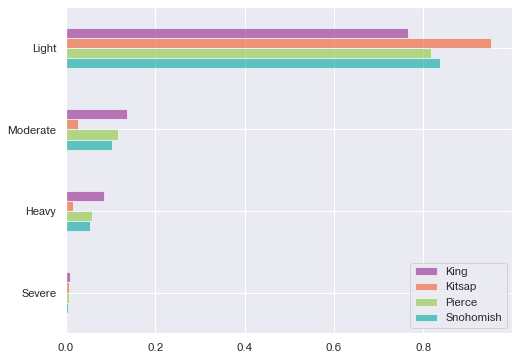

In [7]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

#### AM Peak (7 to 8 AM)

In [8]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,194,368","335,066","941,932","917,171"
Moderate,"658,147","16,094","277,034","230,430"
Heavy,"682,877","9,578","212,000","167,201"
Severe,"84,071","8,551","51,245","11,590"


In [9]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,60.6%,90.7%,63.5%,69.1%
Moderate,18.2%,4.4%,18.7%,17.4%
Heavy,18.9%,2.6%,14.3%,12.6%
Severe,2.3%,2.3%,3.5%,0.9%


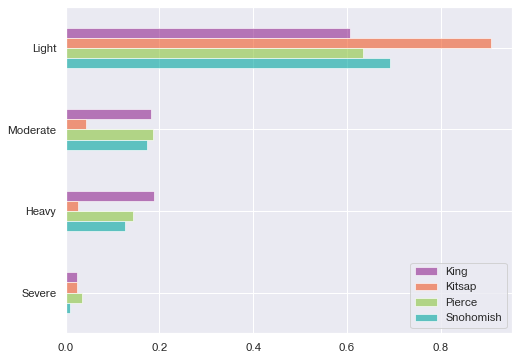

In [10]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

#### PM Peak (5 to 6 PM)

In [11]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,458,524","378,914","1,061,042","1,028,618"
Moderate,"808,435","21,445","298,741","251,024"
Heavy,"685,090","5,950","235,850","171,031"
Severe,"91,592","7,948","17,335","19,513"


In [12]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,60.8%,91.5%,65.8%,70.0%
Moderate,20.0%,5.2%,18.5%,17.1%
Heavy,16.9%,1.4%,14.6%,11.6%
Severe,2.3%,1.9%,1.1%,1.3%


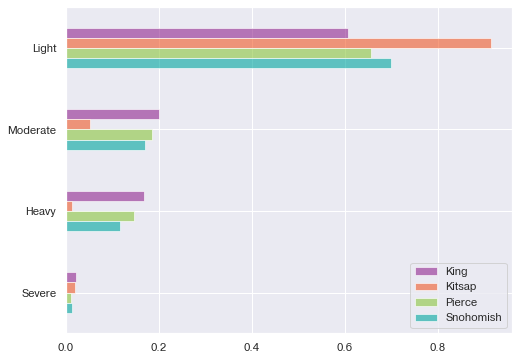

In [13]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

# Freight Congestion
## All Trucks (Heavy & Medium)
#### All Day

In [14]:
df['heavy_truck_vmt'] = df['length']*df['@heavy_truck']
df['medium_truck_vmt'] = df['length']*df['@medium_truck']
df['total_truck_vmt'] = df['heavy_truck_vmt']+df['medium_truck_vmt'] 

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='total_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"4,741,736","396,193","1,598,095","1,706,398"
Moderate,"880,090","6,570","263,918","215,182"
Heavy,"525,121","5,092","121,470","87,612"
Severe,"40,207","2,420","16,072","5,249"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,76.6%,96.6%,79.9%,84.7%
Moderate,14.2%,1.6%,13.2%,10.7%
Heavy,8.5%,1.2%,6.1%,4.3%
Severe,0.6%,0.6%,0.8%,0.3%


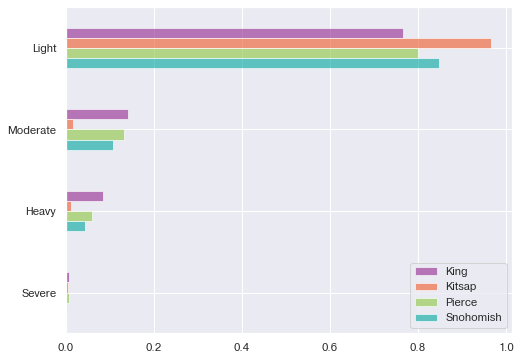

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Heavy Trucks

In [18]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='heavy_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,263,499","150,552","860,909","952,430"
Moderate,"404,415","1,782","155,041","110,628"
Heavy,"238,846","1,631","81,786","42,057"
Severe,"14,572",957,"12,260","1,707"


In [19]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,77.5%,97.2%,77.6%,86.1%
Moderate,13.8%,1.2%,14.0%,10.0%
Heavy,8.2%,1.1%,7.4%,3.8%
Severe,0.5%,0.6%,1.1%,0.2%


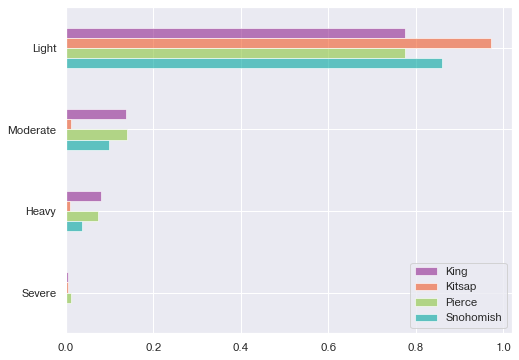

In [20]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Medium Trucks

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')

_df

county,King,Kitsap,Pierce,Snohomish
congestion_category,,,,
Severe,"25,635","1,462","3,812","3,542"
Heavy,"286,275","3,462","39,684","45,555"
Moderate,"475,675","4,788","108,877","104,553"
Light,"2,478,238","245,640","737,185","753,968"


In [22]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,478,238","245,640","737,185","753,968"
Moderate,"475,675","4,788","108,877","104,553"
Heavy,"286,275","3,462","39,684","45,555"
Severe,"25,635","1,462","3,812","3,542"


In [23]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,75.9%,96.2%,82.9%,83.1%
Moderate,14.6%,1.9%,12.2%,11.5%
Heavy,8.8%,1.4%,4.5%,5.0%
Severe,0.8%,0.6%,0.4%,0.4%


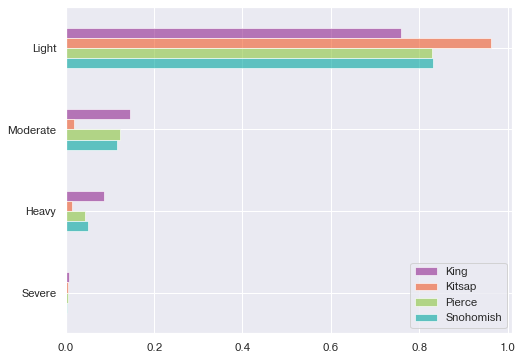

In [24]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');